# Experimental test of the method - data analysis

In [1]:
# standard modules
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
# custom modules
import KetSugar as ks
import MaxLik as ml
import WaveplateBox as wp
import HammerProj as hp

DEG = np.pi/180.
ML_ITER_MAX = 1000
ML_FROB_STOP = 1e-9

std_meas_table = (
    (0, 0),
    (np.pi/4, 0),
    (np.pi/8, 0),
    (-np.pi/8, 0),
    (np.pi/8, np.pi/4),
    (-np.pi/8, -np.pi/4)
)

rev_meas_table = (
    (0, 0),
    (np.pi/4, 0),
    (np.pi/8, 0),
    (-np.pi/8, 0),
    (-np.pi/8, -np.pi/4),
    (np.pi/8, np.pi/4)
)

def get_assumed_rpv(dhwp_proj, dqwp_proj):
    """Build array for maxlik procedure. It takes into account retardance deviation."""
    rpvkets = [ks.dagger(ks.dagger(ks.LO) @ wp.WP(qwp, np.pi/2 + dqwp_proj) @ wp.WP(hwp, np.pi + dhwp_proj)) for hwp, qwp in std_meas_table]
    rpv = np.array([ks.ketbra(ket, ket) for ket in rpvkets])          
    return rpv

def get_cost_function_fwd(tomograms):
    """Create cost function for optimization based on measured tomograms."""
    def cost_function(x):
        dhwp_proj, dqwp_proj = x
        rpv = get_assumed_rpv(dhwp_proj, dqwp_proj)
        rhos = [ml.Reconstruct(tomogram, rpv, ML_ITER_MAX, ML_FROB_STOP, RhoPiVect = True, Renorm = True) for tomogram in tomograms]
        purities = tuple(map(lambda x: ks.Purity(x).real, rhos))
        #return np.ptp(purities)    
        return -np.min(purities)    
    return cost_function

def get_assumed_rpv_rev(dhwp_prep, dqwp_prep):
    """Build array for maxlik procedure. It takes into account retardance deviation. Reversed version."""
    rpvkets = [wp.WP(hwp, np.pi + dhwp_prep) @ wp.WP(qwp, np.pi/2 + dqwp_prep) @ ks.LO for hwp, qwp in rev_meas_table]
    rpv = np.array([ks.ketbra(ket, ket) for ket in rpvkets])    
    return rpv

def get_cost_function_rev(tomograms):
    """Create cost function for optimization based on measured tomograms. This is the reversed version."""
    def cost_function(x):
        dhwp_prep, dqwp_prep = x
        rpv = get_assumed_rpv_rev(dhwp_prep, dqwp_prep)
        rhos = [ml.Reconstruct(tomogram, rpv, ML_ITER_MAX, ML_FROB_STOP, RhoPiVect = True, Renorm = True) for tomogram in tomograms]
        purities = tuple(map(lambda x: ks.Purity(x).real, rhos))
        #it is equivalent to np.ptp(purities) but experimentally more informative 
        return -np.min(purities)    
    return cost_function

def get_calibrations(path):
    """Load datafile and optimize assumed waveplate retardance to minimize purity modulation.
    Args:
        path: (str) path to h5 datafile
    Returns:
        retardance errors of the four waveplates
    """
    results = []
    h5file = h5py.File(path, 'r')
    cost_function_gens = (get_cost_function_fwd, get_cost_function_rev)
    tomo_shapes = [(8,6), (6,8)]
    for i, cost_function_gen in enumerate(cost_function_gens):        
        tomograms = np.array(h5file[f'iter_{i}_int'])
        tomograms_normed = tomograms[:,0]/(tomograms[:,0]+tomograms[:,1])
        tomograms_normed = tomograms_normed.reshape(tomo_shapes[i])
        if i == 1:
            tomograms_normed = tomograms_normed.T
        cost_function = cost_function_gen(tomograms_normed)
        optimum = minimize(cost_function, x0 = (0, 0), method = 'Nelder-Mead')
        assert optimum['success']
        results.extend(optimum['x'])
    dhwp3, dqwp4, dhwp1, dqwp2 = results
    return dhwp1, dqwp2, dhwp3, dqwp4


def hammer_map(rho):
    """
    Assign a point on Bloch sphere to a density matrix. 
    For mixed states, their greatest eigenvector is mapped.
    """
    return hp.Hammer(*hp.BlochToGeo(*hp.RhoToBloch2(rho)), wrapback=True)


MaxLik: Numba Allowed: True => use cycle-based K-vector construction


## Infer retardance deviation of waveplates from the calibration data.

In [3]:
# Load calibration dataset and extract retardance deviation.
retardance_deviations = get_calibrations('data/wp_3_4_13_14_cal_8qwp.h5')
print(np.round(np.array(retardance_deviations)/DEG,1))


[ 4.5 -3.6  4.5 -1.3]


## Test the performance using a set of probe states.

In [5]:
# Target probe states
Nx = 9
Ny = 9
thetas = np.linspace(0, 180, Ny)*DEG
phis = np.linspace(-180, 180, Nx)[1:]*DEG
targets = []
for theta in thetas:
    for phi in ([0] if (theta == 0 or theta == np.pi) else phis):
        targets.append(ks.BlochKet(theta, phi))
target_rhos = [ks.ketbra(ket, ket) for ket in targets]

# Assumed measurement operators for reconstruction
pauli_eigenstates = [ks.LO, ks.HI, ks.HLO, ks.HHI, ks.CLO, ks.CHI]
measurement_operators = ml.MakeRPV([pauli_eigenstates])
c_measurement_operators = get_assumed_rpv(retardance_deviations[2], retardance_deviations[3])
#c_measurement_operators = get_assumed_rpv(4.5*DEG, -1.3*DEG)



In [6]:
print(target_rhos[-1])
hammer_map(target_rhos[-1])


[[3.74939946e-33+0.j 6.12323400e-17+0.j]
 [6.12323400e-17+0.j 1.00000000e+00+0.j]]


(1.7319121124709868e-16, -1.4142135623730951)

In [7]:
# Load test dataset and calculate characteristics.

h5data = h5py.File('data/wp_3_4_13_14_check_58.h5', 'r')
n = 58 #number of probe states
tomograms_n = h5data['iter_0_int'][:,0]/(h5data['iter_0_int'][:,0]+h5data['iter_0_int'][:,1])
tomograms_n = tomograms_n.reshape((n,6))

tomograms_c = h5data['iter_1_int'][:,0]/(h5data['iter_1_int'][:,0]+h5data['iter_1_int'][:,1])
tomograms_c = tomograms_c.reshape((n,6))

rhos_n = [ml.Reconstruct(tomogram, measurement_operators, ML_ITER_MAX, ML_FROB_STOP) for tomogram in tomograms_n]
rhos_n_c = [ml.Reconstruct(tomogram, c_measurement_operators, ML_ITER_MAX, ML_FROB_STOP, RhoPiVect = True, Renorm = True) for tomogram in tomograms_n]
rhos_c = [ml.Reconstruct(tomogram, measurement_operators, ML_ITER_MAX, ML_FROB_STOP) for tomogram in tomograms_c]

purs_n = np.array([ks.Purity(rho).real for rho in rhos_n])
purs_n_c = np.array([ks.Purity(rho).real for rho in rhos_n_c])
purs_c = np.array([ks.Purity(rho).real for rho in rhos_c])
fids_n = np.array([ks.ExpectationValue(ket, rho).real for ket, rho in zip(targets, rhos_n)])
fids_c = np.array([ks.ExpectationValue(ket, rho).real for ket, rho in zip(targets, rhos_c)])
F_mean_n = np.mean(fids_n)
F_mean_c = np.mean(fids_c)

print(f'P: {np.min(purs_n):.5f}->{np.min(purs_n_c):.5f} (ref data, calib. op. meas), {np.min(purs_c):.5f} (calib data)')
print(f'F: {F_mean_n:.5f}->{F_mean_c:.5f}')

P: 0.93830->0.98180 (ref data, calib. op. meas), 0.98297 (calib data)
F: 0.99239->0.99703


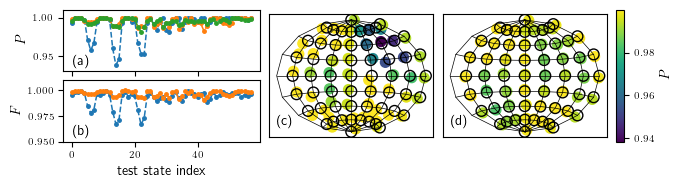

In [11]:
#Produce plot for paper
%matplotlib inline
#Setup font size and plotting style basics
#Font-size
SMALL_SIZE = 7
MEDIUM_SIZE = 10
BIGGER_SIZE = 11

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('lines', markersize = 4) #for single-col
plt.rc('lines', markersize = 5)
plt.rc('lines', markeredgewidth = 1)
plt.rc("errorbar", capsize=1)
plt.rc('lines', linewidth = 1.1)
#use Tex rendering?
plt.rc("text", usetex = True)

labels = [f'({i})' for i in 'abcd']
vmin = np.min(np.concatenate([purs_n, purs_c]))
vmax = np.max(np.concatenate([purs_n, purs_c]))
xys_r = np.array([hammer_map(rho) for rho in target_rhos])
xys_n = np.array([hammer_map(rho) for rho in rhos_n])
xys_c = np.array([hammer_map(rho) for rho in rhos_c])


fig_width = 7 #inch
fig_height = 1
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
layout = '''
ACDE
BCDE
'''
fig, ax = plt.subplot_mosaic(
    layout, figsize=(7,2), 
    gridspec_kw = {
        'width_ratios' : [1.2, 1, 1,0.05]
        })

hp.PlotHammerGrid(ax['C'], 9, 9)
hp.PlotHammerGrid(ax['D'], 9, 9)
im0 = ax['C'].scatter(xys_n[:,0], xys_n[:,1], s = 50, c = purs_n, vmin = vmin, vmax = vmax)
im1 = ax['D'].scatter(xys_c[:,0], xys_c[:,1], s = 50, c = purs_c, vmin = vmin, vmax = vmax)
ax['C'].scatter(xys_r[:,0], xys_r[:,1], s = 60, marker = 'o', edgecolors='black', facecolors='none')
ax['D'].scatter(xys_r[:,0], xys_r[:,1], s = 60, marker = 'o', edgecolors='black', facecolors='none')

for key in 'CD':
    ax[key].set_aspect(1.5)
    ax[key].set_xticks([])
    ax[key].set_yticks([])
ax['A'].set_xticklabels([])

for i, key in enumerate('ABCD'):
    ax[key].text(0.05, 0.1, labels[i], transform = ax[key].transAxes)

ax['B'].set_xlabel('test state index')
ax['A'].plot(purs_n, ".--")
ax['A'].plot(purs_c, ".--")
ax['A'].plot(purs_n_c, ".--")
ax['B'].plot(fids_n, ".--")
ax['B'].plot(fids_c, ".--")
ax['A'].set_ylabel('$P$')
ax['B'].set_ylabel('$F$')
ax['A'].set_ylim(0.93,1.01)
ax['B'].set_ylim(0.95,1.01)

fig.colorbar(im1, cax = ax['E'], label='$P$')

plt.subplots_adjust(
    top=0.923,
    bottom=0.263,
    left=0.107,
    right=0.909,
    hspace=0.14,
    wspace=0.07
)
plt.show()
